# Setup

In [28]:
# %pip install -r requirements.txt


In [29]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import re
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude
from wordcloud import WordCloud, ImageColorGenerator

rc = {
    # "font.family": "serif",  # fonte serifada
    "mathtext.fontset": "cm",  # texto matemático em LaTeX
    "font.size": 14,  # Usar tamanho 12 ou 14
    "axes.axisbelow": True,  # grid abaixo dos dados
    "axes.grid": True,  # grid por padrão
    "text.usetex": False,  # latex em toda a figura
}

%matplotlib inline

plt.rcParams.update(rc)


nltk.download('stopwords', download_dir='./nltk_data')


[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---

# Lendo o texto e tratando os dados de entrada

As palavras foram coletadas de dois formulários:

1. `wc-text-pre.csv`: São as palavras coletadas no formulário de opinião
2. `wc-text-pos.csv`: São as palavras coletadas no formulário de pedido
   


In [30]:
def read_df(fname, replace_newline=False):
    df = pd.read_csv(fname)
    df.columns = ['idx', 'words']

    if replace_newline:
        df.replace('\n', ', ', regex=True, inplace=True)
        df.dropna(inplace=True)

    return df


In [31]:
df1 = read_df('./data/wc-text-pre.csv', True)
df1.head()


,idx,words
0,7,Python
1,12,"Function, C, return, goto"
2,19,"Programar, stress, café, saporra não funciona."
3,21,"Alan Turing, programação, trabalho"
4,31,"Ensino, programação, aprendizado, tecnologia"


In [32]:
df2 = read_df('./data/wc-text-pos.csv', True)
df2.head()


,idx,words
1,2,Lógica
3,4,Determinação
6,7,bugou
8,9,Silício
9,10,C++


In [33]:
df = pd.concat([df1, df2])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 105
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   idx     75 non-null     int64 
 1   words   75 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


## Removendo palavras sem utilidade

Ao invés de tratar o texto de entrada, o a própria classe `WordCloud` tem um método pra remover as stopwords. Deixei esse trecho de código aqui mas seria mais adequado deixar lá embaixo na hora de gerar o wc.

In [34]:
'''
Não sei o motivo do nltk ter problemas com a leitura do arquivo em pasta diferente da 
'/home/$USER', então, melhor ler o arquivo direto
'''

with open('./nltk_data/corpora/stopwords/portuguese') as pt:
    stops = ' '.join(pt.readlines())

with open('./nltk_data/corpora/stopwords/english') as en:
    stops += ' '.join(en.readlines())


stops = stops.replace('\n', '')


In [35]:
l_words = df['words'].to_list()

text = ' '.join(l_words)
text = text.replace(' ', ',')
text = text.replace('\"', '')

text = text.title()  # Inicial maiúscula


### Ajuste ...

Idealmente não precisaria fazer isso aqui, mas devido ao exagero na quantidade de vezes em que 'Eam' foi escrito ...

In [40]:
l = text.split(',')

for i in range(l.count('Eam')):
    l.append('ECO')
    l.append('ECA')
    l.append('EEL')
    l.append('EMB')
    l.append('EMT')
    l.append('EME')
    l.append('EPR')
    l.append('ESS')

# Não precisa mas gera as palavras sem ordem de importância
np.random.shuffle(l)

text = ' '.join(l)
text = re.sub(r'\s+|\.+|\,+', ' ', text).strip()

text


'Ecônomico Bicho? Programação Itabira Automação EME C++ EMT Vagas Return ECO ESS ECO Computação Competência EMB Mais Eam Engenharia Resultado Programa Ódio Desistir Enigma Return Itajubá Garoto Código Turing Lab Otimização EMT Extensão EEL Energia EEL Ctrl+C --Force Ernesto Unifei Computação Cor EME Ambiental Ambiental Diodo EMB EME Em Ferro Caat Realização Unifei Caat Tristeza Eam EPR Developer Provas Computação Programação ESS Meu Elefante ECO Engenharia Ambiental Computação Amor Eam Programa EMB EPR Von Calças EMT EMB Não EMB EME Calango Ambiental Faço Eam Ambiental Bugs Café Caat ECA Seeac EME EEL Computação Controle Function EMB Energia Lotado ECO Ambiental Nuvem Eam Conjunto Uma C++ ECA Eam ECO Discente Codar Camaco EMB EME Estudo Todos ECA EMT Práticas Socorro Ódio EPR Alan ESS Complexo EMT Circuitos ECA Caat Máquina Ônibus Ctrl+V ESS Energia Saporra Busao De Back-End Compilador Tecnologia Alan Elefantes Commit Turing Hardware ECO Power ESS Prédio EMB De Ambiental Npn Full ECA P

---

In [42]:
text.split(' ').count('')

0

# Lendo a imagem

Não é nenhuma mágica (até agora), é só ler a imagem e transformar num array numpy com formato ou *shape* (x, y, 3). Qualquer função de ler imagem serve.

A linha seguinte (`img = img[::3,::3]`) reduz a qualidade da imagem, é útil pra fazer o código rodar mais rápido.

In [11]:
img = np.array(Image.open('./img_in/unifei_logo.png'))
img = img[::3, ::3]


# Processando as bordas

Usando a média do gradiente de Gauss dá pra filtrar a imagem legal e usar o realce das bordas como os eixos para as trocas de cor. A função pode parecer meio maluca à primeira vista. E é mesmo. Vamos ao passo a passo:

1. Normaliza as componentes de cor da imagem para cada canal de cor RGB (aquela parte que divide por 255 e fala `for i in range(3)` que é pra cada canal de cor) e joga an variável `gradient`
2. Tira a média do resultado e joga na variável `edges` 
3. Copia os valores de cor da imagem pra variável `img_mask`
4. Se para cada valor de `edges` for maior que o gatilho escolhido (`mask_threshold`), a imagem terá cor. Caso contrário, não terá.
5. Ufa


In [12]:
gradient = [gaussian_gradient_magnitude(img[:, :, i] / 255., sigma=1) for i in range(3)]
edges = np.mean(gradient, axis=0)

mask_thresh = 0.008
img_mask = img.copy()
img_mask[img_mask.sum(axis=2) == 0] = 255
img_mask[edges > mask_thresh] = 255


# Gerando o WordCloud

Processar a imagem tá praticamente feito, agora basta gerar a nuvem. Algumas considerações:

- rel_scaling: não fez diferença evidente trocar para 0 ou para 1, então deixei em `'auto'`
- max_words: com umas 2000 palavras já dá um resultado aceitável, dá pra usar o comprimento (em caracteres) do próprio texto pra deixar esse valor no automático
  * 5000 palavras demora uns 3m então melhor ir com cuidado 
- font: só especificar o caminho da fonte pro arquivo `.ttf`
- scale: aumenta a escala da imagem. Por padrão e 1 e produz uma imagem de $1000 \times 1000$. Aumentar a escala também melhora a qualidade (e o tamanho do png)

In [13]:
rel_scaling = 'auto'
max_words = 5000
font = './Exo_2/Exo2-VariableFont_wght.ttf'
scale = 2

wc = WordCloud(
    mask=img_mask,
    max_words=max_words,
    font_path=font,
    stopwords=stops,
    scale=scale,
    mode="RGBA",
    background_color=None,
    max_font_size=100,
    random_state=2,
    relative_scaling=rel_scaling,
    min_font_size=1,
    repeat=True)

wc.generate(text)


# Colorindo o WordCloud

Por padrão, a saída do wordcloud é binária (com cor, sem cor, <strike>cor sim cor não</strike>) então usamos uma função mão na roda que extrai as cores sem muito mistério

In [14]:
image_colors = ImageColorGenerator(img)
wc.recolor(color_func=image_colors)


# Salvando o arquivo

Falta só salvar o arquivo agora. O PNG tem uma qualidade suficientemente boa mas pra fabricar a camisa a(s) empresa pede SVG.

- Para salvar em PNG é só usar a função do próprio módulo `to_file('nome_do_arquivo.png')`. Essa função não suporta SVG nativamente, então a gente usa gambiarra:
- Para salvar em SVG a gente usa a função de converter pra SVG (que retorna uma string) e grava essa string num arquivo. Voillá! Temos um Wordcloud!

In [15]:
from datetime import datetime

now = str(datetime.now())

wc_svg = wc.to_svg(embed_font=True)
with open('./img_out/svg/wc_' + now + '.svg', 'w') as f:
    f.write(wc_svg)

wc.to_file(f'./img_out/png/wc_{now}_.png')


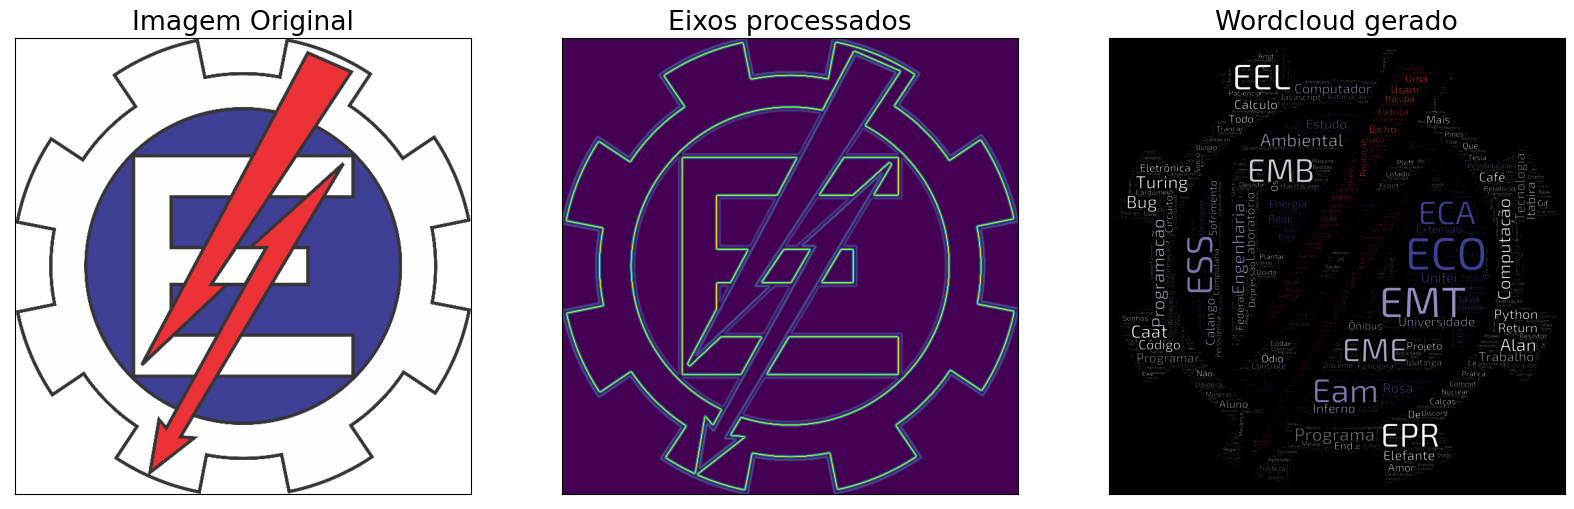

In [16]:
plt.rc('font', size=16)

f, ax = plt.subplots(ncols=3, figsize=(20, 10))

ax[0].imshow(img)
ax[1].imshow(edges)
ax[2].imshow(wc, interpolation='bilinear')

for i in ax:
    i.set(
        xticks=[], yticks=[]
    )

ax[0].set(
    title='Imagem Original'
)

ax[1].set(
    title='Eixos processados'
)

ax[2].set(
    title='Wordcloud gerado',
    facecolor='black'
)

plt.show()


# Vendo as palavras mais frequentes

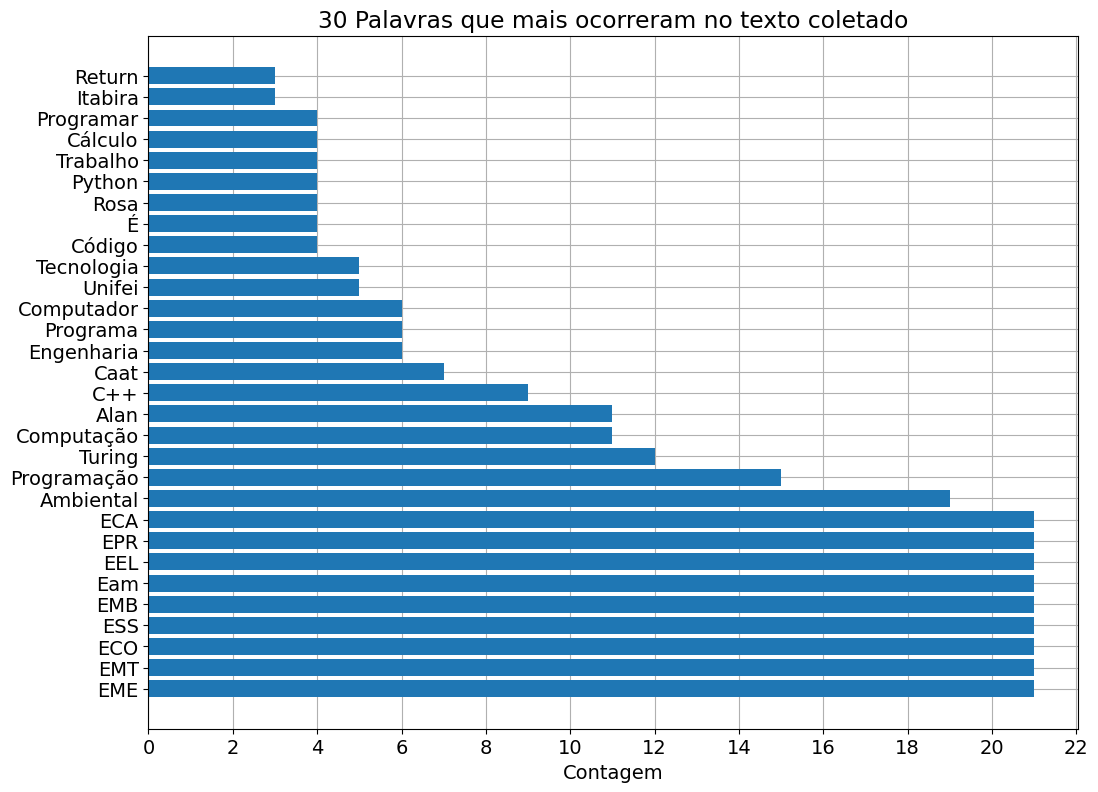

In [44]:
from collections import Counter

ctr = Counter(text.split(' '))
k, v = list(zip(*ctr.most_common(30)))

plt.figure(figsize=(12, 9))

plt.barh(k, v)

plt.title('30 Palavras que mais ocorreram no texto coletado')
plt.xticks(range(0, 24, 2))
plt.xlabel('Contagem')
plt.show()


![](./img_out/wc_final.png)